In [30]:
import pybullet as p
import pybullet_data
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import time

class FrankaReachEnv(gym.Env):
    def __init__(self, render=False):
        self.render = render
        if not p.isConnected():
            self.physicsClient = p.connect(p.GUI if render else p.DIRECT)
        self.timestep = 1 / 240.
        self.max_steps = 5000
        self.step_count = 0
        self.robot_id = None
        self.target_pos = np.array([0.5, 0.0, 0.6]) # target position in cartesian space
        self.target_ori_euler = p.getQuaternionFromEuler([0, np.pi, 0]) # target orientation in cartesian space
        self.action_space = spaces.Box(low=-1, high=1, shape=(7,), dtype=np.float32)
        obs_low = np.array([-np.pi] * 7 + [-2, -2, 0] + [-np.pi] * 3)
        obs_high = np.array([np.pi] * 7 + [2, 2, 2] + [np.pi] * 3)
        self.observation_space = spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)

    def reset(self, seed=None, options=None):
        if not p.isConnected():
            self.physicsClient = p.connect(p.GUI if self.render else p.DIRECT)

        p.resetSimulation()
        self.step_count = 0
        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        p.setGravity(0, 0, -9.8)
        p.loadURDF("plane.urdf")
        self.robot_id = p.loadURDF("franka_panda/panda.urdf", useFixedBase=True)
        init_q = np.array([0, -0.785398163397, 0, -2.3561944901, 0, 1.57079632679, 0.785398163397])
        for i in range(7):
            p.resetJointState(self.robot_id, i, init_q[i]) # initial joint angle
            p.setJointMotorControl2(self.robot_id, i, controlMode=p.VELOCITY_CONTROL, force=0) # cancel position control
        for _ in range(10):
            p.stepSimulation()
        obs_data = self._get_obs()

        return obs_data['flat_obs'], {}

    def _get_obs(self):
        # Get joint information
        num_joints = p.getNumJoints(self.robot_id)
        joint_indices = [i for i in range(num_joints) if p.getJointInfo(self.robot_id, i)[2] != p.JOINT_FIXED]
        num_dof = len(joint_indices)
        joint_states = p.getJointStates(self.robot_id, joint_indices)
        joint_positions = [s[0] for s in joint_states]
        joint_velocities = [s[1] for s in joint_states]
        joint_accelerations = [0.0] * num_dof

        # End-effector state
        ee_state = p.getLinkState(self.robot_id, 11, computeForwardKinematics=True)
        ee_pos = ee_state[0]
        ee_ori_quat = ee_state[1]
        ee_ori_euler = p.getEulerFromQuaternion(ee_ori_quat)

        # C(q, q_dot) @ q_dot + G(q)
        coriolis_gravity = p.calculateInverseDynamics(
            self.robot_id, joint_positions, joint_velocities, joint_accelerations
        )

        # Observation
        obs = {
            'joint_positions': np.array(joint_positions[:7]),
            'joint_velocities': np.array(joint_velocities[:7]),
            'ee_pos': np.array(ee_pos),
            'ee_ori_euler': np.array(ee_ori_euler),
            'coriolis_gravity': np.array(coriolis_gravity[:7]),
            'flat_obs': np.array(joint_positions[:7] + list(ee_pos) + list(ee_ori_euler), dtype=np.float32)
        }
        return obs

    def step(self, action):
        self.step_count += 1
        obs_data = self._get_obs()
        q = obs_data['joint_positions']
        q_dot = obs_data['joint_velocities']
        ee_pos = obs_data['ee_pos']
        ee_ori = obs_data['ee_ori_euler']
        coriolis_gravity = obs_data['coriolis_gravity']

        # Cartesian space position error
        pos_err = ee_pos - self.target_pos
        dist = np.linalg.norm(pos_err)

        # Set joint limits so Inverse Kinematics will not return a weird pose
        lower_limits = [-0.28973, -1.7628, -2.8973, -3.0718, -2.8973, -0.0175, -2.8973, -0.1, -0.1]
        upper_limits = [0.28973, 1.7628, 2.8973, -1.5698, 2.8973, 3.7525, 2.8973, 0.1, 0.1]
        joint_ranges = [u - l for u, l in zip(upper_limits, lower_limits)]
        rest_poses = [0, -0.785398163397, 0, -2.3561944901, 0, 1.57079632679, 0.785398163397, 0, 0]

        # Joint space angle and velocity error
        desired_joint_positions = p.calculateInverseKinematics(self.robot_id, 11, self.target_pos, self.target_ori_euler, lowerLimits=lower_limits, upperLimits=upper_limits, jointRanges=joint_ranges, restPoses=rest_poses)
        error_q = q - desired_joint_positions[:7]
        error_q_dot = q_dot # desired joint velocity are all 0

        # Apply external force
        link_index = 11
        force = [10, 10, 10]
        position = [0, 0, 0]
        p.applyExternalForce(
            objectUniqueId=self.robot_id,
            linkIndex=link_index,
            forceObj=force,
            posObj=position,
            flags=p.WORLD_FRAME
        )

        # Controller
        # Kp = np.array([600.0, 600.0, 600.0, 600.0, 250.0, 150.0, 50.0])
        Kp = np.array([60.0, 60.0, 60.0, 60.0, 25.0, 15.0, 5.0])
        Kd = np.array([5.0, 5.0, 5.0, 5.0, 3.0, 2.5, 1.5])
        tau = np.array(coriolis_gravity)[:7] - Kp * error_q - Kd * error_q_dot
        joint_indices = np.array([0, 1, 2, 3, 4, 5, 6])
        p.setJointMotorControlArray(
            bodyUniqueId=self.robot_id,
            jointIndices=joint_indices,
            controlMode=p.TORQUE_CONTROL,
            forces=tau.tolist()
        )
        p.stepSimulation()
        time.sleep(self.timestep)

        reward = -np.mean(error_q ** 2)
        done = self.step_count >= self.max_steps

        return obs_data['flat_obs'], reward, done, False, {}

    def close(self):
        p.disconnect()


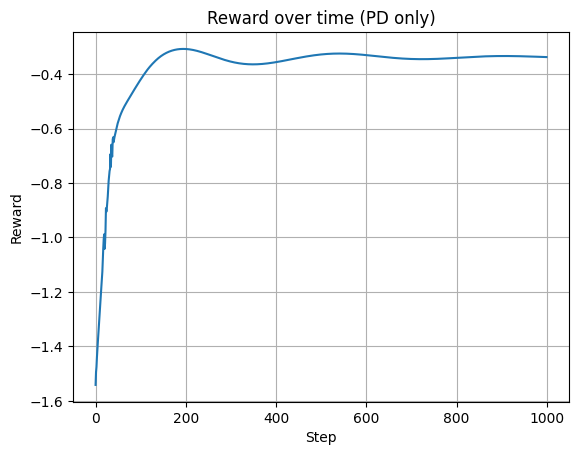

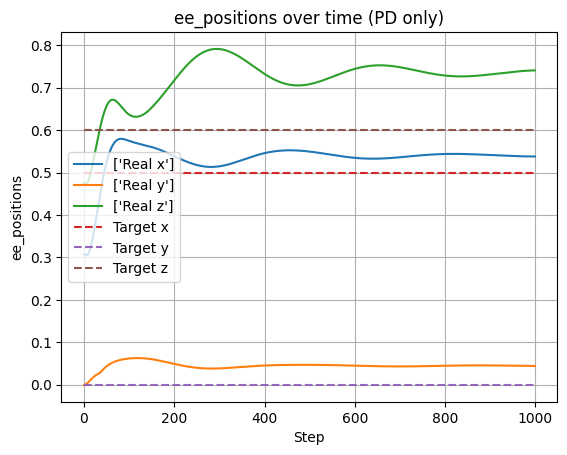

In [31]:
import matplotlib.pyplot as plt

env = FrankaReachEnv(render=True)
obs, _ = env.reset()

rewards = []
ee_positions = []

for _ in range(1000):
    dummy_action = [0.0] * 7
    obs, reward, done, _, _ = env.step(dummy_action)
    rewards.append(reward)
    ee_pos = obs[7:10]
    ee_positions.append(ee_pos)
    if done:
        print(f"Episode finished early at step {_}")
        break

env.close()

plt.figure()
plt.plot(rewards)
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title("Reward over time (PD only)")
plt.grid()
plt.show()

target_pos = np.array([0.5, 0.0, 0.6])
plt.figure()
plt.plot(np.array(ee_positions)[:,0], label=['Real x'])
plt.plot(np.array(ee_positions)[:,1], label=['Real y'])
plt.plot(np.array(ee_positions)[:,2], label=['Real z'])
plt.plot(np.full(1000, target_pos[0]), label="Target x", linestyle='--')
plt.plot(np.full(1000, target_pos[1]), label="Target y", linestyle='--')
plt.plot(np.full(1000, target_pos[2]), label="Target z", linestyle='--')
plt.xlabel("Step")
plt.ylabel("ee_positions")
plt.title("ee_positions over time (PD only)")
plt.grid()
plt.legend()
plt.show()